<a href="https://colab.research.google.com/github/onni-Q/lecture_notebooks/blob/main/Week4_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
#2025 hack to overcome dependency issues of gensim and numpy. You have to restart the session, as gensim needs a lower numpy version.

#!pip install gensim

Please run the cells below to set up the environment.

In [185]:
#Keep cell
%%capture

import os
import nltk

try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')
  nltk.download('punkt_tab')

try:
  nltk.data.find('corpora/stopwords')
except LookupError:
  nltk.download('stopwords')


try:
  import gensim
except:
  !pip install gensim #--no-build-isolation
  import gensim

if not(os.path.exists('sotu_all_new.csv')):
  print('Downloading sotu_all_new.csv\n')
  !wget https://raw.githubusercontent.com/goto4711/cdai/main/sotu_all_new.csv

if not(os.path.exists('20070123.txt')):
  print('Downloading 20070123.txt\n')
  !wget https://raw.githubusercontent.com/goto4711/cdai/main/20070123.txt

if not(os.path.exists('hate-vocab-eng.csv')):
  print('Downloading hate-vocab-eng.csv')
  !wget https://raw.githubusercontent.com/goto4711/cdai/main/hate-vocab-eng.csv

# Cultural Data Forms - Texts

In this session, we work on texts as cultural data forms. The idea of cultural forms stems from Foucault: https://blogs.nottingham.ac.uk/criticalmoment/2014/05/22/what-is-psychology-badiou-interviews-foucault-in-1965/. The second part of the course is all dedicated to the new forms of culture or cultural forms we have with the arrival of digital data. By the end of this lecture, you will understand:
- The concept of unstructured text data.
- How to make text into data with standard text-preprocessing steps (tokenization, lowercasing, stopword removal, punctuation/number removal).
- How to perform basic linguistic statistics.
- How to create and interpret simple text-analysis tools like word clouds.
- How to use more advanced techniques like topic modelling or Named Entity Recognition.  
- How to use a dictionary-based approach to sentiment analysis/hate speech detection.

This lecture aims to show the whole range of possibilities once you have made unstructured texts into data. We show lots and lots of tools that you can then use, which also means that all of this is just a taster.

Compared to our previous work on structured data, we start dealing with unstructured data when we talk about cultural data forms. The methods are not very different from the kind of structured data analysis, which we have already discussed. But the data is quite different: "Unstructured data (or unstructured information) is information that either does not have a pre-defined data model or is not organized in a pre-defined manner. Unstructured information is typically text-heavy, but may contain data such as dates, numbers, and facts as well. This results in irregularities and ambiguities that make it difficult to understand using traditional programs as compared to data stored in fielded form in databases or annotated (semantically tagged) in documents. In 1998, Merrill Lynch said 'unstructured data comprises the vast majority of data found in an organization, some estimates run as high as 80%'. It's unclear what the source of this number is, but nonetheless it is accepted by some. Other sources have reported similar or higher percentages of unstructured data." (https://en.wikipedia.org/wiki/Unstructured_data).

We start with texts as cultural data forms. We have already talked about texts a little bit from time to time. In this session, we will finally find out how to be able to do text analysis by ourselves.

Text analysis is an advanced field in the world of computational analytics - many of your teachers from from the Institute for Logic, Language and Computation (https://en.wikipedia.org/wiki/Institute_for_Logic,_Language_and_Computation) -, and we can rely on a very long tradition of doing text analysis and very established methods. Besides, it is fun and maybe at the same time the dominant form in social and cultural data analysis - simply because we humans work so much with texts, documents, etc.

## Preparing textual data: The State of the Union Addresses

We have had texts for a long time. So, in this session we will also focus a bit on historical-cultural analysis and concentrate on timelines. We will go back further in history and mainly work with the US State of the Union Address in the lecture before looking into contemporary issues like hate speech in the workshop.

The lecture allows us to look into the past state of the political constitution of the USA. The State of the Union (SOTU) data is taken from http://stateoftheunion.onetwothree.net/index.shtml and provides access to the corpus of all the State of the Union addresses from 1790 to 2022. SOTU allows you to explore how specific words gain and lose prominence over time and explore the historical context.

We have done all the hard work of downloading the SOTU data for you. Just run the cell below to set up some necessary libraries and load the dataframe `sotu_df`.

In [186]:
#Keep cell
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]

sotu_df = pd.read_csv('sotu_all_new.csv')
sotu_df.tail()

,rownames,speechtext,year,date
231,20180130.html,"Mr. Speaker, Mr. Vice President, Members of C...",2018,20180130
232,20190205.html,"Madam Speaker, Mr. Vice President, Members of...",2019,20190205
233,20200204.html,"Madam Speaker, Mr. Vice President, Members of...",2020,20200204
234,20210428.html,Madame Speaker. Madame Vice President. No pre...,2021,20210428
235,20220301.html,"Madam Speaker, Madam Vice President, and our F...",2022,20220301


You can see the structure of the dataframe, but you cannot completely see what is in the speechtext column. There is too much text. Try and print out the first text entry with `sotu_df.loc[0, 'speechtext']`. Do you remember how this works?

In [187]:
sotu_df.loc[0, 'speechtext']

' Fellow-Citizens of the Senate and House of Representatives: I embrace with great satisfaction the opportunity which now presents itself of congratulating you on the present favorable prospects of our public affairs. The recent accession of the important state of North Carolina to the Constitution of the United States (of which official information has been received), the rising credit and respectability of our country, the general and increasing good will toward the government of the Union, and the concord, peace, and plenty with which we are blessed are circumstances auspicious in an eminent degree to our national prosperity. In resuming your consultations for the general good you can not but derive encouragement from the reflection that the measures of the last session have been as satisfactory to your constituents as the novelty and difficulty of the work allowed you to hope. Still further to realize their expectations and to secure the blessings which a gracious Providence has pl

The dataframe also contains the column 'year' and 'date'.

Let's check out the types of these values. We can do this in many different ways in Pandas. Try `sotu_df.info()`.

In [188]:
sotu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rownames    236 non-null    object
 1   speechtext  236 non-null    object
 2   year        236 non-null    int64 
 3   date        236 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 7.5+ KB


You can also use `sotu_df.dtypes` to print out the data types directly.

In [189]:
sotu_df.dtypes

,0
rownames,object
speechtext,object
year,int64
date,int64


The rownames and speechtexts look ok as strings ('object'). But the date is an int64 and not recognized as a date.

Looking back at the output of the first cell, `sotu_df's` date is clearly a date-string in the format YYYYMMDD. Pandas has the powerful `pd.to_datetime()` function that can parse such character strings and transform them into Python's date objects. The advantage is that we can then compare dates with each other, add dates to other dates, etc. and all this across different ways of representing dates.

Run `sotu_df['date'] = pd.to_datetime(sotu_df['date'], format='%Y%m%d')`. `format='%Y%m%d'` tells Pandas to expect a sequence of characters in 'date', where the first four are the year (including the century), the next two are the month and the final two are the day - with no spaces or separators in between. This is explained here: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior.

In [190]:
sotu_df['date'] = pd.to_datetime(sotu_df['date'], format='%Y%m%d')
sotu_df.dtypes

,0
rownames,object
speechtext,object
year,int64
date,datetime64[ns]


We want the years to be strings because we will use them as titles to speeches and not as numeric years. Type in `sotu_df['year'] = sotu_df['year'].astype(str)`. Do you remember astype? str indicates the string type.

In [191]:
sotu_df['year'] = sotu_df['year'].astype(str)
sotu_df.dtypes

,0
rownames,object
speechtext,object
year,object
date,datetime64[ns]


Fighting with different formats of date and time is a key part of analysing culture and society computationally. For some past events, for instance, we do not know exact dates or times and have to work with estimates. Sometimes, we only know the approximate time span of when, say, a Roman consul lived. This can cause a lot of issues.

Runing `sotu_df.info()` again will confirm that all the columns are now of the desired types.

In [192]:
sotu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   rownames    236 non-null    object        
 1   speechtext  236 non-null    object        
 2   year        236 non-null    object        
 3   date        236 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 7.5+ KB


Try to reproduce this with Gemini and ask it to load a `sotu_df_gemini` dataframe from 'sotu_all_new.csv' and make sure that date is of type datetime64. Print out the structure of the new dataframe.

With `sotu_df`, we have a collection of documents reflecting over 200 years of US history in the words of each president. It is time to do something with it and 'text-mine' it. Text Mining is the process of deriving meaningful information from natural language text.

As text mining has a long history, there are many tools, tools, tools to run diverse analyses. We start with basic linguistics analyses using the NLTK toolkit.

# Tools, tools, tools

## NLTK and the steps of text analysis

Natural Language Processing (NLP) is a component of text mining performing a special kind of linguistic analysis that essentially helps a machine 'read' text. The Natural Language Toolkit (NLTK; https://www.nltk.org) is a Python package for natural language processing. It is in parts a bit outdated by now, but often still the beginning of Python text analysis and therefore widely used. If you are interested, why not check out the book (https://www.nltk.org/book/).

In this section, we are going to cover some of the most commonly used NLP methods with the NLTK package and employ them to analyse the historical content of the SOTU-speeches. To this end, we create first a so-called corpus. A corpus is term originating from the linguistics community. All you need to know about a corpus is that it is basically a collection of text documents. In Python, you can create a corpus from many sources (online or local) and from many different formats such as plain text or PDF.

We move on and just import NLTK with `import nltk`.

In [193]:
import nltk

Today we want to progress by addressing concrete research tasks. Hopefully, by the end of today you will be able to reproduce some of them.

The first task we set ourselves is to understand historical policy differences. The last SOTU address of the Republican George W. Bush was in 2008, while the first one of the Democrat Barack Obama was in 2009. These years were also the height of a very severe financial crisis. So, we expect interesting changes in content.

To identify these changes, we would like to produce a word cloud (https://en.wikipedia.org/wiki/Tag_cloud) to compare the most frequent terms in both speeches in order to understand differences. Let us first create a smaller sample of the data containing only the speeches of 2008 and 2009. We can use pandas `.loc` by selecting the rows that contain the column value 2008 or 2009 to create a new `sotu_2008_2009` dataframe with the speeches of 2008 and 2009.

Run `sotu_2008 = sotu_df.loc[sotu_df['year']=='2008','speechtext'].item()`. Observe that year is a string and we need to use '2008' and not just 2008. You should know how this works, but `item()` might be new? It gets the content of the cell you are addressing in the dataframe. Check out the documentation if you want.

In [194]:
sotu_2008_text = sotu_df.loc[sotu_df['year']=='2008','speechtext'].item()
sotu_2008

' Madam Speaker, Vice President Cheney, Members of Congress, distinguished guests, and fellow citizens: Seven years have passed since I first stood before you at this rostrum. In that time, our country has been tested in ways none of us could have imagined. We have faced hard decisions about peace and war, rising competition in the world economy, and the health and welfare of our citizens. These issues call for vigorous debate, and I think its fair to say weve answered that call. Yet history will record that amid our differences, we acted with purpose. And together, we showed the world the power and resilience of American self-government. All of us were sent to Washington to carry out the peoples business. That is the purpose of this body. It is the meaning of our oath. And it remains our charge to keep. The actions of the 110th Congress will affect the security and prosperity of our nation long after this session has ended. In this election year, let us show our fellow Americans that 

Now, please do the same thing with 2009 to create `sotu_2009_text`.

In [195]:
sotu_2009_text = sotu_df.loc[sotu_df['year'] == '2009', 'speechtext'].item()
sotu_2009_text

" Madame Speaker, Mr. Vice President, Members of Congress, and the First Lady of the United States: I've come here tonight not only to address the distinguished men and women in this great chamber, but to speak frankly and directly to the men and women who sent us here. I know that for many Americans watching right now, the state of our economy is a concern that rises above all others.  And rightly so.  If you haven't been personally affected by this recession, you probably know someone who has -- a friend; a neighbor; a member of your family.  You don't need to hear another list of statistics to know that our economy is in crisis, because you live it every day.  It's the worry you wake up with and the source of sleepless nights.  It's the job you thought you'd retire from but now have lost; the business you built your dreams upon that's now hanging by a thread; the college acceptance letter your child had to put back in the envelope.  The impact of this recession is real, and it is ev

Next we create a corpus for each year. We first need to *tokenize* the words, which means we break the text into its units, which are words. Tokenization is the first important step how computers read texts: https://www.datacamp.com/blog/what-is-tokenization.

NLTK has a simple tokenizer for us but there are many choices in Python, too. You might want to Google 'tokenization Python'?

Let's import the NLTK word tokenizer first with `from nltk.tokenize import word_tokenize`.

In [196]:
from nltk.tokenize import word_tokenize

Now, we create two corpora of words for each text: `corpus_2008` and `corpus_2009`. Run `corpus_2008 = word_tokenize(sotu_2008_text)`.

In [197]:
corpus_2008 = word_tokenize(sotu_2008_text)
corpus_2008

['Madam',
 'Speaker',
 ',',
 'Vice',
 'President',
 'Cheney',
 ',',
 'Members',
 'of',
 'Congress',
 ',',
 'distinguished',
 'guests',
 ',',
 'and',
 'fellow',
 'citizens',
 ':',
 'Seven',
 'years',
 'have',
 'passed',
 'since',
 'I',
 'first',
 'stood',
 'before',
 'you',
 'at',
 'this',
 'rostrum',
 '.',
 'In',
 'that',
 'time',
 ',',
 'our',
 'country',
 'has',
 'been',
 'tested',
 'in',
 'ways',
 'none',
 'of',
 'us',
 'could',
 'have',
 'imagined',
 '.',
 'We',
 'have',
 'faced',
 'hard',
 'decisions',
 'about',
 'peace',
 'and',
 'war',
 ',',
 'rising',
 'competition',
 'in',
 'the',
 'world',
 'economy',
 ',',
 'and',
 'the',
 'health',
 'and',
 'welfare',
 'of',
 'our',
 'citizens',
 '.',
 'These',
 'issues',
 'call',
 'for',
 'vigorous',
 'debate',
 ',',
 'and',
 'I',
 'think',
 'its',
 'fair',
 'to',
 'say',
 'weve',
 'answered',
 'that',
 'call',
 '.',
 'Yet',
 'history',
 'will',
 'record',
 'that',
 'amid',
 'our',
 'differences',
 ',',
 'we',
 'acted',
 'with',
 'purpose'

Please, create `corpus_2009` by modifying the last cell.

In [198]:
corpus_2009 = word_tokenize(sotu_2008_text)
corpus_2009

['Madam',
 'Speaker',
 ',',
 'Vice',
 'President',
 'Cheney',
 ',',
 'Members',
 'of',
 'Congress',
 ',',
 'distinguished',
 'guests',
 ',',
 'and',
 'fellow',
 'citizens',
 ':',
 'Seven',
 'years',
 'have',
 'passed',
 'since',
 'I',
 'first',
 'stood',
 'before',
 'you',
 'at',
 'this',
 'rostrum',
 '.',
 'In',
 'that',
 'time',
 ',',
 'our',
 'country',
 'has',
 'been',
 'tested',
 'in',
 'ways',
 'none',
 'of',
 'us',
 'could',
 'have',
 'imagined',
 '.',
 'We',
 'have',
 'faced',
 'hard',
 'decisions',
 'about',
 'peace',
 'and',
 'war',
 ',',
 'rising',
 'competition',
 'in',
 'the',
 'world',
 'economy',
 ',',
 'and',
 'the',
 'health',
 'and',
 'welfare',
 'of',
 'our',
 'citizens',
 '.',
 'These',
 'issues',
 'call',
 'for',
 'vigorous',
 'debate',
 ',',
 'and',
 'I',
 'think',
 'its',
 'fair',
 'to',
 'say',
 'weve',
 'answered',
 'that',
 'call',
 '.',
 'Yet',
 'history',
 'will',
 'record',
 'that',
 'amid',
 'our',
 'differences',
 ',',
 'we',
 'acted',
 'with',
 'purpose'

Next, we need to clean the data. There is a lot of bad data in text and this is an important process. The Bad Data Handbook - Cleaning Up The Data So You Can Get Back To Work by McCallum and published by O'Reilly is still an excellent summary of this other side of big data. The bigger the data the more likely it is also somehow 'bad'!

But it is not just bad data we are concerned with. We simply need to do a lot of steps for a computer to recognize the differences in language. These steps are often the same. So, if nothing else please pay attention to the steps of this so-called pipeline. You will see them again and again in different orders.

We want to first make all words **lower_case**. This makes it easier to analyse them, as say 'House' and 'house' generally have the same meaning.

Second, we also want to **remove numbers** from our word cloud, as they do not really add meaning in our context.

Thirdly, the NLTK tokenizer sees **punctuation** as words. So, we need to do something about that.

Python has a function `isalpha()`, that checks whether a token consists only of alphabetic letters [A-Za-Z]. This will also remove all numbers.

Try `corpus_2008 = [word.lower() for word in corpus_2008 if word.isalpha()]`.

In [199]:
corpus_2008 = [word.lower() for word in corpus_2008 if word.isalpha()]
corpus_2008

['madam',
 'speaker',
 'vice',
 'president',
 'cheney',
 'members',
 'of',
 'congress',
 'distinguished',
 'guests',
 'and',
 'fellow',
 'citizens',
 'seven',
 'years',
 'have',
 'passed',
 'since',
 'i',
 'first',
 'stood',
 'before',
 'you',
 'at',
 'this',
 'rostrum',
 'in',
 'that',
 'time',
 'our',
 'country',
 'has',
 'been',
 'tested',
 'in',
 'ways',
 'none',
 'of',
 'us',
 'could',
 'have',
 'imagined',
 'we',
 'have',
 'faced',
 'hard',
 'decisions',
 'about',
 'peace',
 'and',
 'war',
 'rising',
 'competition',
 'in',
 'the',
 'world',
 'economy',
 'and',
 'the',
 'health',
 'and',
 'welfare',
 'of',
 'our',
 'citizens',
 'these',
 'issues',
 'call',
 'for',
 'vigorous',
 'debate',
 'and',
 'i',
 'think',
 'its',
 'fair',
 'to',
 'say',
 'weve',
 'answered',
 'that',
 'call',
 'yet',
 'history',
 'will',
 'record',
 'that',
 'amid',
 'our',
 'differences',
 'we',
 'acted',
 'with',
 'purpose',
 'and',
 'together',
 'we',
 'showed',
 'the',
 'world',
 'the',
 'power',
 'and',

I hope you remember how list comprehension works? If not and before you move on, please check https://www.w3schools.com/python/python_lists_comprehension.asp. We will use it a lot for the analysis of texts.

The above statement runs through all the words in `corpus_2008` and keeps only those that are not numbers with `word.isalpha()`. To those, it applies `lower()`, which does what its name says it does: https://www.w3schools.com/python/ref_string_lower.asp.

Next filter out the numbers in `corpus_2009`.

In [200]:
corpus_2009 = [word.lower() for word in corpus_2008 if word.isalpha()]
corpus_2009

['madam',
 'speaker',
 'vice',
 'president',
 'cheney',
 'members',
 'of',
 'congress',
 'distinguished',
 'guests',
 'and',
 'fellow',
 'citizens',
 'seven',
 'years',
 'have',
 'passed',
 'since',
 'i',
 'first',
 'stood',
 'before',
 'you',
 'at',
 'this',
 'rostrum',
 'in',
 'that',
 'time',
 'our',
 'country',
 'has',
 'been',
 'tested',
 'in',
 'ways',
 'none',
 'of',
 'us',
 'could',
 'have',
 'imagined',
 'we',
 'have',
 'faced',
 'hard',
 'decisions',
 'about',
 'peace',
 'and',
 'war',
 'rising',
 'competition',
 'in',
 'the',
 'world',
 'economy',
 'and',
 'the',
 'health',
 'and',
 'welfare',
 'of',
 'our',
 'citizens',
 'these',
 'issues',
 'call',
 'for',
 'vigorous',
 'debate',
 'and',
 'i',
 'think',
 'its',
 'fair',
 'to',
 'say',
 'weve',
 'answered',
 'that',
 'call',
 'yet',
 'history',
 'will',
 'record',
 'that',
 'amid',
 'our',
 'differences',
 'we',
 'acted',
 'with',
 'purpose',
 'and',
 'together',
 'we',
 'showed',
 'the',
 'world',
 'the',
 'power',
 'and',

The most frequently used words in a document generally carry its meaning. But, we also have so-called **stopwords** such as 'the', 'a', 'or', etc., which usually carry less meaning than other expressions if they have meaning at all. You will see what kind of words I mean by checking out NLTK's stopwords corpus.

Run the cell below.

In [201]:
#Keep cell
from nltk.corpus import stopwords
stopword_list = list(stopwords.words('english'))
stopword_list[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

Do you agree that these words do not really carry meaning in English? Let's try the Dutch version. Run the cell below.

In [202]:
#Keep cell
list(stopwords.words('dutch'))[:15]

['de',
 'en',
 'van',
 'ik',
 'te',
 'dat',
 'die',
 'in',
 'een',
 'hij',
 'het',
 'niet',
 'zijn',
 'is',
 'was']

As you can see much of what we are working on here is very dependent on the language. This makes it all very difficult. We have most tools and resources for English. This is why we are focusing on it for now.

Stopwords should be removed to concentrate on the most important words. Let us do so by checking for each word in our corpus whether it is in the stopword list.

Run `corpus_2008 = [word for word in corpus_2008 if word not in stopword_list]`.

In [203]:
corpus_2008 = [word for word in corpus_2008 if word not in stopword_list]
corpus_2008

['madam',
 'speaker',
 'vice',
 'president',
 'cheney',
 'members',
 'congress',
 'distinguished',
 'guests',
 'fellow',
 'citizens',
 'seven',
 'years',
 'passed',
 'since',
 'first',
 'stood',
 'rostrum',
 'time',
 'country',
 'tested',
 'ways',
 'none',
 'us',
 'could',
 'imagined',
 'faced',
 'hard',
 'decisions',
 'peace',
 'war',
 'rising',
 'competition',
 'world',
 'economy',
 'health',
 'welfare',
 'citizens',
 'issues',
 'call',
 'vigorous',
 'debate',
 'think',
 'fair',
 'say',
 'weve',
 'answered',
 'call',
 'yet',
 'history',
 'record',
 'amid',
 'differences',
 'acted',
 'purpose',
 'together',
 'showed',
 'world',
 'power',
 'resilience',
 'american',
 'us',
 'sent',
 'washington',
 'carry',
 'peoples',
 'business',
 'purpose',
 'body',
 'meaning',
 'oath',
 'remains',
 'charge',
 'keep',
 'actions',
 'congress',
 'affect',
 'security',
 'prosperity',
 'nation',
 'long',
 'session',
 'ended',
 'election',
 'year',
 'let',
 'us',
 'show',
 'fellow',
 'americans',
 'recogn

Please, remove the stopwords from `corpus_2009` next.

In [204]:
corpus_2009 = [word for word in corpus_2008 if word not in stopword_list]
corpus_2009

['madam',
 'speaker',
 'vice',
 'president',
 'cheney',
 'members',
 'congress',
 'distinguished',
 'guests',
 'fellow',
 'citizens',
 'seven',
 'years',
 'passed',
 'since',
 'first',
 'stood',
 'rostrum',
 'time',
 'country',
 'tested',
 'ways',
 'none',
 'us',
 'could',
 'imagined',
 'faced',
 'hard',
 'decisions',
 'peace',
 'war',
 'rising',
 'competition',
 'world',
 'economy',
 'health',
 'welfare',
 'citizens',
 'issues',
 'call',
 'vigorous',
 'debate',
 'think',
 'fair',
 'say',
 'weve',
 'answered',
 'call',
 'yet',
 'history',
 'record',
 'amid',
 'differences',
 'acted',
 'purpose',
 'together',
 'showed',
 'world',
 'power',
 'resilience',
 'american',
 'us',
 'sent',
 'washington',
 'carry',
 'peoples',
 'business',
 'purpose',
 'body',
 'meaning',
 'oath',
 'remains',
 'charge',
 'keep',
 'actions',
 'congress',
 'affect',
 'security',
 'prosperity',
 'nation',
 'long',
 'session',
 'ended',
 'election',
 'year',
 'let',
 'us',
 'show',
 'fellow',
 'americans',
 'recogn

Let us next prepare a simple word cloud for both the corpora, by joining them. We can simply add the two lists with +. Create `corpus_2008_2009 = corpus_2008 + corpus_2009` and print out its first 10 elements with `corpus_2008_2009[:10]`.

In [205]:
corpus_2008_2009 = corpus_2008 + corpus_2009
corpus_2008_2009[:10]

['madam',
 'speaker',
 'vice',
 'president',
 'cheney',
 'members',
 'congress',
 'distinguished',
 'guests',
 'fellow']

The wordcloud we want to create needs a single text as input. With `text_2008_2009 = ' '.join(corpus_2008_2009)`, you can do that. It took me a while to understand this command, but it is best to simple translate this as join all elements of the list and add a whitespace ' ' in-between. This command is often used to move back from the tokenized text in a list of strings to the original text. For the time being, just remember it as an option and ask Gemini to help you out if you forgot how to merge a list of strings into a text in Python.

In [206]:
text_2008_2009 = ' '.join(corpus_2008_2009)

As you might have already guessed, this word cloud exercise does not just help to make word clouds, but introduces you to many of the steps that you need to do for text analysis. You always split the text into words. Then, clean those words to the ones you want and then join them back into a text. That's it ...

We are ready to create a word cloud. First load the corresponding function with `from wordcloud import WordCloud`.

In [207]:
from wordcloud import WordCloud

The word cloud function has a lot of customization options: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud. You could have, for instance, removed the stopwords directly but where would have been the fun in that. But we would like to use white as a background colour and only use 500 words. We also set width and height.

So, please type in `wc_2008_2009 = WordCloud(background_color = 'white', width=1500, height=1000, max_words=500).generate(text_2008_2009)`. `Generate` takes our text and sends it to the word cloud function.

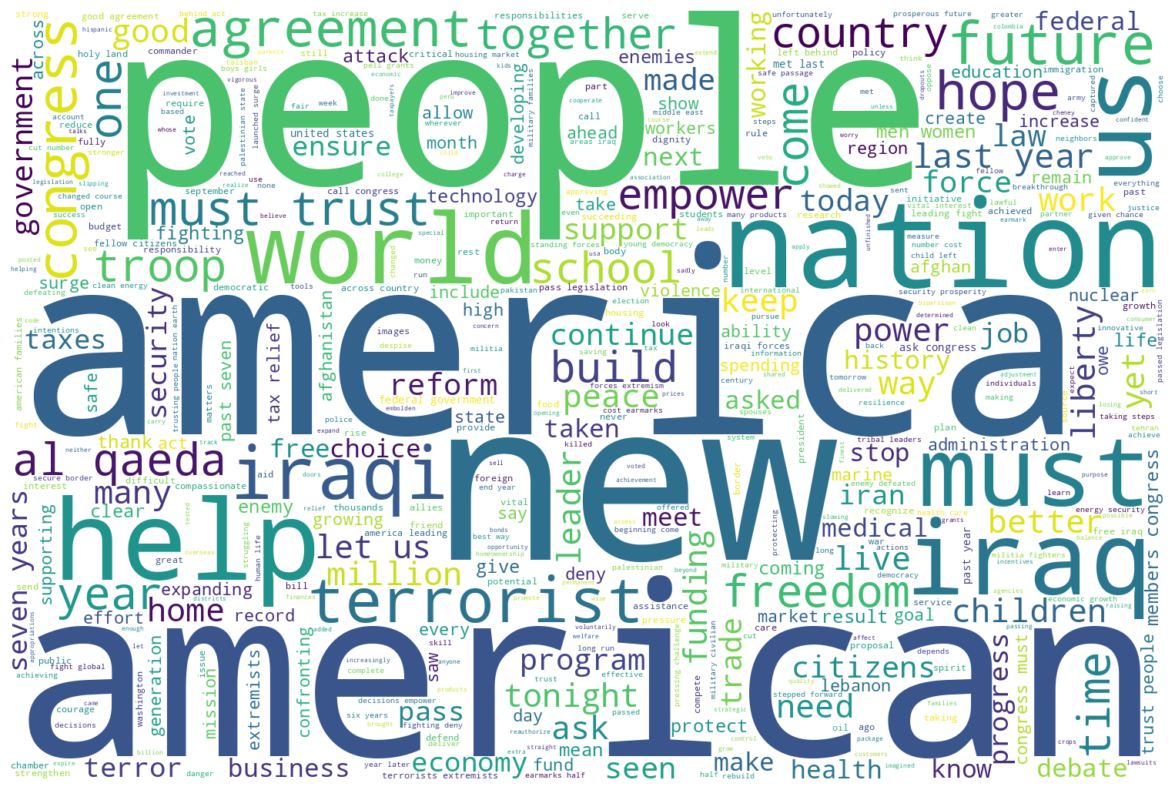

In [208]:
wc_2008_2009 = WordCloud(background_color = 'white', width=1500, height=1000, max_words=500).generate(text_2008_2009)
# Display the word cloud
plt.figure(figsize=(15, 10))  # You can adjust the size of the figure
plt.imshow(wc_2008_2009, interpolation='bilinear')  # Display the word cloud image
plt.axis('off')  # Hide axes
plt.show()  # Show the plot

Even for such a small corpus this might take a while. You can see the result with Matplotlib's `plt.imshow(wc_2008_2009)`.

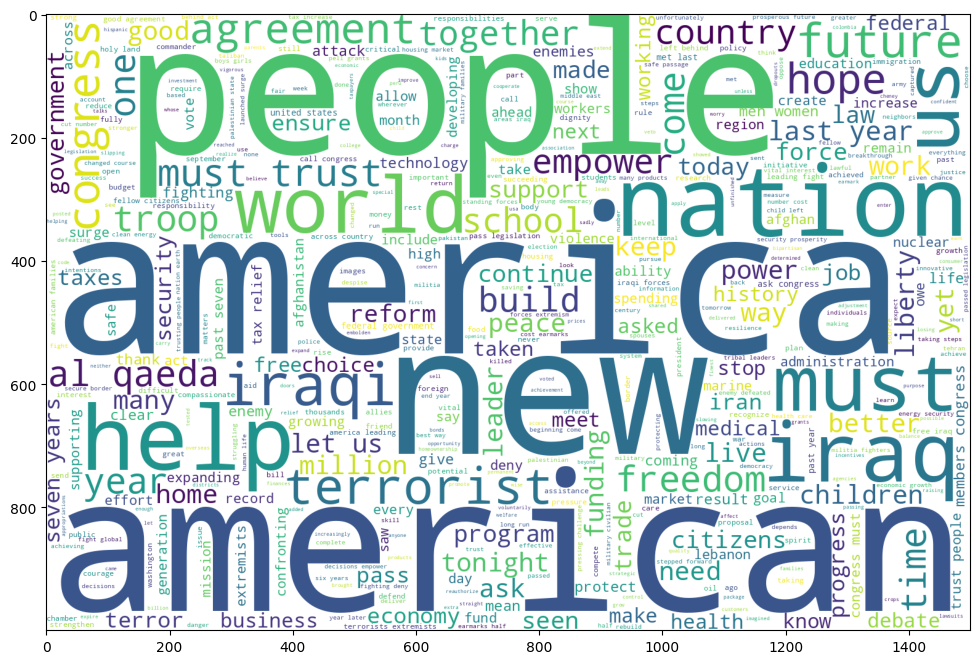

In [209]:
plt.imshow(wc_2008_2009)

Nice. Check out https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb for a great overview of the power of word clouds in Python.

We can clearly see that America is important in 2008 and in 2009 as well as the people of course.

More interesting is probably the comparison of the 2008 speech by Bush with the 2009 speech by Obama. But for these we need to create two different corpora to make two different word clouds. It is a good exercise to repeat our steps once more.

Run `text_2008 = ' '.join(corpus_2008)` to generate the text of 2008.

In [210]:
text_2008 = ' '.join(corpus_2008)
text_2008

'madam speaker vice president cheney members congress distinguished guests fellow citizens seven years passed since first stood rostrum time country tested ways none us could imagined faced hard decisions peace war rising competition world economy health welfare citizens issues call vigorous debate think fair say weve answered call yet history record amid differences acted purpose together showed world power resilience american us sent washington carry peoples business purpose body meaning oath remains charge keep actions congress affect security prosperity nation long session ended election year let us show fellow americans recognize responsibilities determined meet let us show republicans democrats compete votes cooperate results time expanding opportunity protecting country made good progress yet unfinished business us american people expect us get done work ahead must guided philosophy made nation great americans believe power individuals determine destiny shape course history beli

Please, also create `text_2009` in the same way.

In [211]:
text_2009 = ' '.join(corpus_2009)
text_2009

'madam speaker vice president cheney members congress distinguished guests fellow citizens seven years passed since first stood rostrum time country tested ways none us could imagined faced hard decisions peace war rising competition world economy health welfare citizens issues call vigorous debate think fair say weve answered call yet history record amid differences acted purpose together showed world power resilience american us sent washington carry peoples business purpose body meaning oath remains charge keep actions congress affect security prosperity nation long session ended election year let us show fellow americans recognize responsibilities determined meet let us show republicans democrats compete votes cooperate results time expanding opportunity protecting country made good progress yet unfinished business us american people expect us get done work ahead must guided philosophy made nation great americans believe power individuals determine destiny shape course history beli

Run the following cell to plot both texts next to each other.

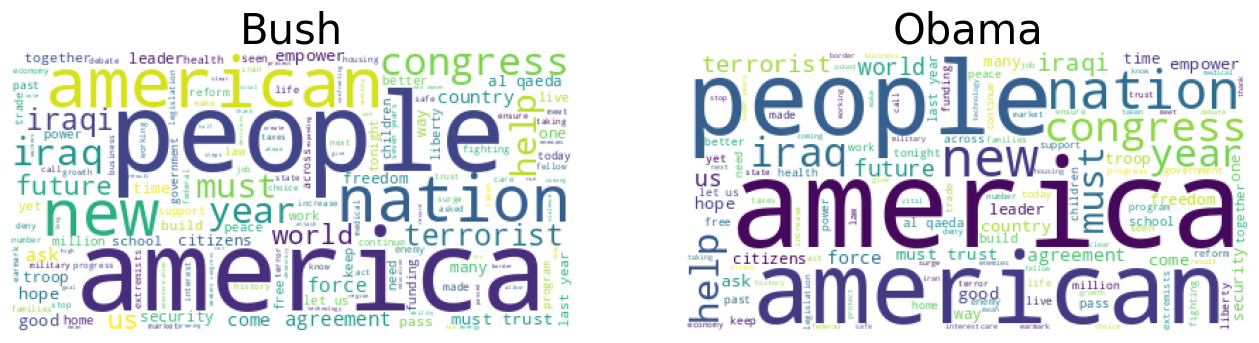

In [212]:
#Keep cell

plt.subplot(1,2,1)
plt.plot()
plt.imshow(WordCloud(background_color = 'white').generate(text_2008))
plt.title('Bush', fontsize = 30)
plt.axis("off")

plt.subplot(1,2,2)
plt.plot()
plt.imshow(WordCloud(background_color = 'white').generate(text_2009))
plt.title('Obama', fontsize = 30)
plt.axis("off")
plt.show()

We can clearly see that Obama concentrated more on the economy while Bush’s favourite topic was the war on terror. The times have changed a lot between them, which is why we have chosen them as examples. We are quite happy with this insight, but we also feel we can do better.

## Simple Linguistic Statistics: counting words, tfidf, etc.

Word clouds deliver quite a bit of insight. We now feel confident to explore the whole corpus. In the end, we would like to establish some simple linguistic statistics such as the most frequent words/terms in a collection as well as word trends that tell us about the ups and downs of concepts during the history of policy-making in the USA. Check out http://stateoftheunion.onetwothree.net/sotuGraph/index.html for a visualisation to compare two concepts in the SOTU speeches.

In order to analyse the documents, we will simply count their words and create what is called a document-term matrix. According to https://en.wikipedia.org/wiki/Document-term_matrix, 'a document-term matrix (DTM) is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.' Hidden behind this rather technical description is the fact that DTMs and vectorization in general are the principal way how computers read texts by counting words or generally tokens, which can be words but also characters or subwords.

In sklearn, we have a very powerful function called `CountVectorizer` to do all the hard work for us. First load it with `from sklearn.feature_extraction.text import CountVectorizer`.

In [213]:
from sklearn.feature_extraction.text import CountVectorizer

Now, it gets a bit complicated. We first define the vectorizer with `vectorizer = CountVectorizer(lowercase = True, stop_words = 'english', token_pattern = '[a-zA-Z]+')`.

This does not only count words, but it also cleans the texts as we had done before. It lowercases words, removes stopwords and keeps only non-numeric character with the regular expression `'[a-zA-Z]{3,}+'`. Interested in how we constructed `token_pattern`? Then, you will enjoy this week's DataCamp class, which covers these so-called regular expressions in some detail. I find regular expressions hard and use Gemini/ChatGPT to help me define them. In fact, this is how I produced `token_pattern` for this exercise.

In [214]:
vectorizer = CountVectorizer(lowercase = True, stop_words = 'english', token_pattern = '[a-zA-Z]+')

Let's ask Gemini what the two expressions from the last two cells do. Run: "Please explain: from sklearn.feature_extraction.text import CountVectorizer and vectorizer = CountVectorizer(lowercase = True, stop_words = 'english', token_pattern = '[a-zA-Z]{3,}')"

In the language of sklearn, we need to fit and transform the vectorizers to create vectors for the speeches. You might remember that this is similar to what we have done in the machine-learning lessons.

Run `vectors = vectorizer.fit_transform(sotu_df['speechtext'])`.

In [215]:
vectors = vectorizer.fit_transform(sotu_df['speechtext'])

Now, we can create `dtm_df` by running the cell below. It uses a dataframe with the matrix of vectors as an input. The column names are the features of vectorizer which are the words in the speeches. And, we index the dataframe with the `sotu_df` years.

In [216]:
#Keep cell
dtm_df = pd.DataFrame(vectors.toarray(),
                      columns = vectorizer.get_feature_names_out(),
                      index = sotu_df['year'])

dtm_df.head()

,aaa,aana,aaron,abandon,abandoned,abandoning,abandonment,abandons,abate,abated,...,zimbabwe,zimbabwean,zinc,zion,zollverein,zone,zones,zoological,zooming,zuloaga
year,,,,,,,,,,,,,,,,,,,,,
1790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Where we have a document-term-matrix, we also have a term-document-matrix with the terms in the rows and documents in the columns.

Running the cell below, can you see the difference? Rows and columns are swapped or - formally spoken - transposed.

In [217]:
#Keep cell
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase = True, stop_words = 'english', token_pattern = '[a-zA-Z][a-zA-Z][a-zA-Z]+')
vec = tfidf.fit_transform(sotu_df['speechtext'])

pd.DataFrame(vec.toarray().transpose(), index=tfidf.get_feature_names_out(), columns = sotu_df['year']).head()

year,1790,1790,1791,1792,1793,1794,1795,1796,1797,1798,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
aana,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
abandon,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.025095,...,0.0,0.0,0.008815,0.0,0.0,0.0,0.0,0.008954,0.0,0.006747
abandoned,0.0,0.0,0.0,0.0,0.0,0.0,0.027858,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


The last example also shows you how to use the tf-idf vectorizer in Python: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html.

The syntax is the same, but TfidfVectorizer is often preferred, as it considers not only frequent words (TF) but also those that do not appear across too many documents (IDF) and are therefore specific. According to https://en.wikipedia.org/wiki/Tf%E2%80%93idf: 'TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.'

In both matrices, we mainly see a lot of zero values. Many words are simply missing from many documents, which means that the resulting DTM and TDM are very sparse.

To focus a bit more on relevant words, we can, for example, sort the DTM in ascending order for a certain year ('1791'). Years are our rows.

Run `dtm_df.sort_values(by='1791',ascending=False, axis=1).head()`. `by` gives the index to sort by. We set `ascending = False`. With `axis = 1`, we focus on rows.

In [218]:
dtm_df.sort_values(by='1791',ascending=False, axis=1).head()

,states,united,public,proper,government,important,provision,measures,objects,law,...,falseness,falsely,falsehoods,falsehood,false,fallujah,falls,falling,fallibility,falsity
year,,,,,,,,,,,,,,,,,,,,,
1790,4,4,5,3,4,2,2,4,1,1,...,0,0,0,0,0,0,0,0,0,0
1790,3,2,5,0,3,0,1,3,3,2,...,0,0,0,0,0,0,0,0,0,0
1791,18,17,10,7,7,7,7,6,6,6,...,0,0,0,0,0,0,0,0,0,0
1792,5,5,5,6,3,0,7,4,2,6,...,0,0,0,0,0,0,0,0,0,0
1793,24,22,7,1,3,2,1,2,2,5,...,0,0,0,0,1,0,0,0,0,0


We can also view only parts of the dataframe and sort for each year separately and compare them with another year.

Let's try and do this for 2008 and 2009. First set `dtm_df_2008_2009 = dtm_df.loc[['2008', '2009'], :]` to create a specific dataframe looking at 2008 and 2009.

In [219]:
dtm_df_2008_2009 = dtm_df.loc[['2008', '2009'], :]

Then, let's sort this according to Bush's speech. You can use again the function `sort_values()`, which you should already know. Run `dtm_df_2008_2009 = dtm_df_2008_2009.sort_values(by='2008', ascending=False, axis = 1)`.

In [220]:
dtm_df_2008_2009 = dtm_df_2008_2009.sort_values(by='2008', ascending=False, axis = 1)

Now type in `dtm_df_2008_2009.iloc[:,:15]` to print out the 15 top terms.

In [221]:
dtm_df_2008_2009.iloc[:,:15]

,people,america,congress,new,year,iraq,american,help,nation,trust,terrorists,future,forces,world,ask
year,,,,,,,,,,,,,,,
2008,30,30,27,25,24,22,20,19,18,17,14,13,13,13,12
2009,20,18,10,20,9,4,25,8,12,2,2,10,2,11,5


We can see some clear differences between Bush and Obama. Iraq, for instance, disappears almost completely in Obama's speech. Bush seems to also repeat some top words more frequently that are not so important to Obama. It would be interesting to now sort this according to Obama's speech, but we want to move on.

We could also check the total word count/length of each speech by summing up the values of each of the columns. Pandas has the `sum`-function for that: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html. Please, run `dtm_df.sum(axis=1).sort_values(ascending = False).head(10)` for the 10 longest speeches. Can you match them to presidents? Wikipedia is your friend.

In [222]:
dtm_df.sum(axis=1).sort_values(ascending = False).head(10)

,0
year,
1981,18193
1946,13528
1907,11841
1912,11316
1905,10777
1911,10563
1906,10107
1898,9407
1848,8909


Interesting! Please now find the 10 shortest speeches. Hint: `tail(10)` is your friend.

In [223]:
dtm_df.sum(axis=1).sort_values(ascending = False).tail(10)

,0
year,
1795,858
1804,852
1792,846
1793,798
1973,748
1809,732
1799,654
1800,580
1790,553


We are also interested in the words/terms and their frequencies, which will tell us more about the contents of the various speeches. With `sum()`, we just change the axis to columns to find the most frequently used ten words across all the speeches. Try it with `dtm_df.sum(axis=0).sort_values(ascending = False).head(10)`.

In [224]:
dtm_df.sum(axis=0).sort_values(ascending = False).head(10)

,0
government,7119
states,6546
congress,5060
united,4889
people,4182
year,4077
country,3511
s,3413
great,3292
public,3103


You can now split up the DTM into particular years or words, etc. and compare the most frequently used words for all the different combinations. It's easy, no?

I also like corrwith (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html), which we can use to see which words correlate with other words like 'peace'. If they correlate, they appear frequently together. Why might this be interesting?

Run `dtm_df.corrwith(dtm_df['peace']).sort_values(ascending=False).head(10)`. It tells Pandas to pair-wise correlate all columns in `dtm_df` with the 'peace' column and sort according the highest correlations. 1 is the highest correlation and 0 the lowest.

In [225]:
dtm_df.corrwith(dtm_df['peace']).sort_values(ascending=False).head(10)

,0
peace,1.000000
war,0.593356
forces,0.554735
nations,0.543102
military,0.537989
army,0.519512
contributions,0.510698
peoples,0.499278
occupation,0.480706
effort,0.471407


Find the word associations of 'war' then ...

In [226]:
dtm_df.corrwith(dtm_df['war']).sort_values(ascending=False).head(10)

,0
war,1.000000
recommended,0.720531
unliquidated,0.719072
expenditures,0.714407
wartime,0.708884
substandard,0.707692
prewar,0.707260
reconversion,0.701607
dollars,0.700072
lend,0.694264


Well, it seems that peace is mainly a thing of war and war is strongly correlated with 'recommended'! Quite sad now about the world, we move on from the simple linguistic statistics we have done so far - mainly based on word frequencies. Next, we enter the domain of word trends.

We would like to plot word trends, as we have seen them in the lecture. We already have the dataframe for that, which is the one with all the word counts for each year, let's use that to plot the trend of 'america' over the years. We simply select `df_america = dtm_df['america']`. Also print out the last couple of rows of `df_america`.

In [227]:
df_america = dtm_df['america']
df_america.tail()

,america
year,
2018,27
2019,25
2020,40
2021,48
2022,44


Such easy availability of the word frequencies is the real power of DTMs.

We would like to plot the word trends next. But first we have to reset the standard figure size in our notebooks. We increased it earlier (without telling you) to make the word clouds more visible. Run the cell below.

In [228]:
#Keep cell

plt.rcParams['figure.figsize'] = [8, 4]

We already know how to plot a simple numerical series in Pandas and type with confidence: `df_america.plot()`.

<Axes: xlabel='year'>

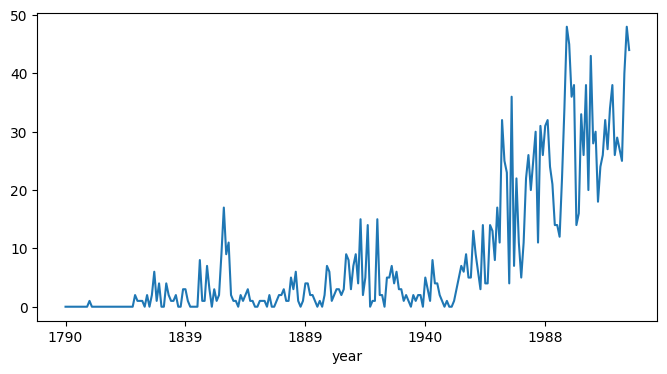

In [229]:
df_america.plot()

For comparison, we add another line-plot about citizens. Try `dtm_df[['america', 'citizen']].plot()`.

<Axes: xlabel='year'>

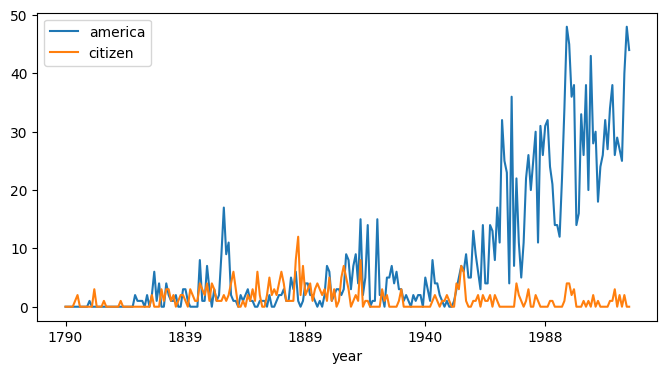

In [230]:
dtm_df[['america', 'citizen']].plot()

Overall, the plot is not very nice. This is part of the limitation of the built-in plotting function. It is a quick solution but often not a very pretty one. Good for data exploration but not representation!

Try word trends yourself. Create a new plot for the historical development of the idea of 'history'.

<Axes: xlabel='year'>

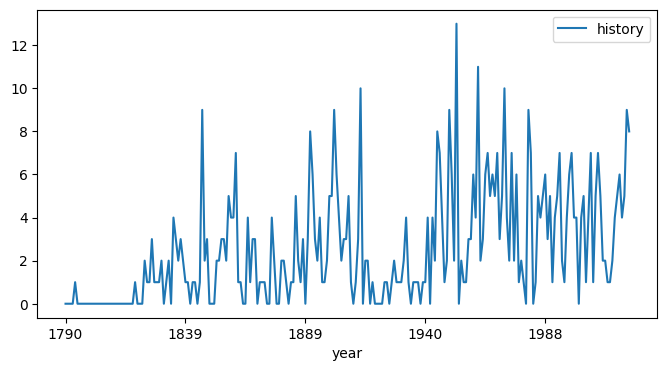

In [231]:
dtm_df[['history']].plot()

Finally, let's practice our Gemini skills again. Ask it to "generate a document term matrix dtm_df_gemini from the texts in sotu_df. Then show the correlations of the term 'peace'."

## Topic Modelling: Bringing words together.

Wouldn't it be nice if we could compare not just words but whole topics across documents in a collection? This is what the advanced technique topic modelling does. Topic modelling summarises a collection of texts into a predefined number of topics, each consisting of several words. Have a look at http://journalofdigitalhumanities.org/2-1/topic-modeling-and-digital-humanities-by-david-m-blei/. Check out https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/ for a nice and easy overview of topic modelling. Previously, topic models have been the most popular method for the data projects later in this semester. So, you might want to pay extra attention now.

Topic models, in a nutshell, are a type of statistical language models used for uncovering hidden structures in a collection of texts. Topic modelling is popular, as it requires only minimal text organisation. Computers can learn topics by themselves. There are, however, known limitations of topic models with regard to the interpretation they help with. There is no guarantee that the automatically derived topics will correspond to what people would consider to be interesting topics/themes. They may be too specific or general, identical to other topics or they may be framings of larger topics, as opposed to genuinely distinct topics. Finally (and in common with other computational analysis techniques), the performance of topic modelling depends upon the quality and structure of the data/text. As always there is no free lunch with these kinds of techniques, and we should be worried that interpreting topic models does not become like 'reading tea leaves' (https://proceedings.neurips.cc/paper/2009/file/f92586a25bb3145facd64ab20fd554ff-Paper.pdf).

We will use a topic modelling technique called Latent Dirichlet Allocation: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation. Try and understand the Wikipedia article, but you will learn better from just trying it. First load the corresponding function with `from sklearn.decomposition import LatentDirichletAllocation`.

In [232]:
from sklearn.decomposition import LatentDirichletAllocation

Now, we can use our vectorizered texts to fit the topic models with `lda = LatentDirichletAllocation(n_components=5, random_state=4711).fit(vectors)`. You should recognize the steps of sklearn? `n_components = 5` means that we want to find 5 topics. `random_state=4711` controls as always the stochastic nature of topic modelling. We have to provide the number of topics in advance. This is another limitation - similar to what we have discussed for clustering.

In [233]:
lda = LatentDirichletAllocation(n_components=5, random_state=4711).fit(vectors)

Run the next cell to print out ten terms associated with each of the topics.

In [234]:
#Keep cell
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

    print()


print("\nTopics in LDA model:")
feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, 5)


Topics in LDA model:
Topic #0:
government congress great war national
Topic #1:
mexico states war texas mexican
Topic #2:
states government united congress year
Topic #3:
s people new america world
Topic #4:
states government united public congress



So how do we interpret this? Remember our struggles with clustering? Interpretation is often difficult for unsupervised methods like clustering or topic models. It shows the top 5 keywords that contribute to each topic.

For example, the keywords in my topic 0 are: "government federal year congress world". This might be different for you, as the topic modelling is initiated with random values. The topics and their words might therefore be different.

We can also identify the top topics for each speech. Run the next cell. Please, note it only shows a random sample of 20 speeches for presentation reasons. If you are interested, I have used topic models in https://www.nature.com/articles/s41599-024-02668-4, which also has more advanced visualisations.

In [235]:
#Keep cell

import random

doc_topic = lda.transform(vectors)

for n in sorted(random.sample(range(doc_topic.shape[0]), 20)):
    topic_most_pr = doc_topic[n].argmax()
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 1 topic: 4

doc: 31 topic: 4

doc: 48 topic: 4

doc: 51 topic: 4

doc: 73 topic: 2

doc: 84 topic: 2

doc: 97 topic: 2

doc: 101 topic: 2

doc: 114 topic: 2

doc: 122 topic: 2

doc: 123 topic: 0

doc: 144 topic: 0

doc: 146 topic: 0

doc: 165 topic: 0

doc: 190 topic: 3

doc: 200 topic: 3

doc: 202 topic: 3

doc: 212 topic: 3

doc: 215 topic: 3

doc: 231 topic: 3



Of course, Gemini can do all of this. Ask it to create a topic model `lda_gemini` from `sotu_df['speechtext']` for five topics. Then, ask it to print out the top 5 words per topic.

If you have time, it could be fun to go back to the topics you have found and try and give each of them a title that describes them. Sometimes this is not so easy, because the corpus is quite small. But try your best.


## Information Extraction: People, places, organisations, etc.

Another commonly used text mining tool is information extraction (https://en.wikipedia.org/wiki/Information_extraction). With information extraction, we can retrieve ideas and concepts directly from texts.

We would like to concentrate on the information extraction service spaCy (https://spacy.io) that has a great Python toolkit. To get a feeling about what we are planning to do, go to https://explosion.ai/demos/displacy-ent and try a few texts.

Great stuff, no? Who, what, where and when are very important questions in social and cultural research and named entity extraction provides a way to address them.

First, load the library with `import spacy`.

In [236]:
import spacy

spaCy comes with various pipelines that help create the extractions. We will use `en_core_web_sm`, a small English pipeline trained on written web-texts (blogs, news, comments) in English. Type in `nlp = spacy.load('en_core_web_sm')`.

In [237]:
nlp = spacy.load('en_core_web_sm')

We will use this example also to introduce another important skill for text analysis, which is reading in external (text) files. https://www.w3schools.com/python/python_file_open.asp presents a nice tutorial how to read an external text file. We learn directly from an example. Try `file = open('20070123.txt', 'r')` to open for read-only a file at the location '20070123.txt'.

In [238]:
file = open('20070123.txt', 'r')

Next, read the text from the file with `text = file.read()`. In the same cell also type in `text[:100]` to print out the first 100 characters of the text.

In [239]:
text = file.read()
text[:100]

'George W. Bush\nJanuary 23, 2007\nTO THE CONGRESS OF THE UNITED STATES:\nThank you very much. Tonight, '

To be honest, I often forget the syntax of such important but not very frequent tasks like reading a text file. This is where ChatGPT and Gemini really come in handy. Ask Gemini to read the file '20070123.txt' into a variable called `text_gemini`.

It is clearly Bush's State of the Union.

spaCy's nlp command extracts all the linguistic features for us from a text. There are many such features, and you will see an example soon. It is best to learn by doing here.

Run `doc = nlp(text)`.

In [240]:
doc = nlp(text)

You can display the output by running the cell below.

In [241]:
#Keep cell

spacy.displacy.render(doc, style='ent', jupyter=True)

What you can see here, are only the extracted entities like person, organisation, etc. spaCy actually targets many more linguistic features.

E.g., spaCy can also visualise dependency parsing (https://spacy.io/usage/visualizers), which is another popular technique, as it shows nouns, subjects, etc. and how they relate. Run the cell below.

In [242]:
#Keep cell

spacy.displacy.render(nlp("This is a sentence."), style='dep', jupyter=True)

But we want to focus on named entity extraction and see what we can do with these entities. Let's check what kind of entities we can find in Bush's speech. Type in:
```
[(entity.text, entity.label_) for entity in doc.ents][:20]
```
This parses through the entities of the doc (doc.ents) and retrieves the first 20 with their texts and labels (https://spacy.io/usage/linguistic-features#named-entities).

In [243]:
[(entity.text, entity.label_) for entity in doc.ents][:20]

[('George W. Bush', 'PERSON'),
 ('January 23, 2007', 'DATE'),
 ('THE CONGRESS OF THE UNITED STATES', 'ORG'),
 ('Tonight', 'TIME'),
 ('first', 'ORDINAL'),
 ('the State of the Union', 'ORG'),
 ('his day', 'DATE'),
 ("Thomas D'Alesandro", 'PERSON'),
 ('Baltimore', 'GPE'),
 ('Maryland', 'GPE'),
 ('Roosevelt', 'PERSON'),
 ('Truman', 'PERSON'),
 ('Nancy', 'PERSON'),
 ('tonight', 'TIME'),
 ('the House of Representatives', 'ORG'),
 ('Two', 'CARDINAL'),
 ('House', 'ORG'),
 ('Senate', 'ORG'),
 ('tonight', 'TIME'),
 ('Tim Johnson', 'PERSON')]

What next? How about mapping the locations? First, let's take a look at them ('GPE' or 'Geopolitical Entity') with `[ent for ent in doc.ents if ent.label_ in ['GPE']][:20]`. There are also 'LOC' entities in spaCy, but we ignore those for the time being.

In [244]:
[ent for ent in doc.ents if ent.label_ in ['GPE']][:20]

[Baltimore,
 Maryland,
 America,
 Washington,
 D.C.,
 America,
 America,
 States,
 America,
 America,
 America,
 America,
 America,
 Washington,
 the United States,
 America,
 America,
 America,
 the United States,
 America]

`sca.locations_spacy(doc)` in the next cell is a little custom function that maps them. Running this might take a while, as it needs to first geocode them with Openstreetmap: https://www.geoapify.com/openstreetmap-geocoding. Try it by running the next cell. You can reuse the function `locations_spacy()` in other work. Ignore any warnings for now.

In [245]:
#Keep cell

import geopandas as gpd
import geopy
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium.plugins import FastMarkerCluster

def locations_spacy(doc):
    locator = geopy.geocoders.Nominatim(user_agent='mygeocoder')
    geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
    locations = [ent for ent in doc.ents if ent.label_ in ['GPE']]
    locations_geocoded = []
    for l in locations:
        try:
            locations_geocoded.append(geocode(l).point)
        except:
            continue
    locations_geocoded = [(l[0], l[1]) for l in locations_geocoded]
    fm = folium.Map(location=[38.305542, -30.384108], tiles='cartodbpositron', zoom_start = 2)
    FastMarkerCluster(data=locations_geocoded).add_to(fm)
    return fm

#locations_spacy(doc)
locations_spacy(doc[500:2500]) #doc[500:2500] for demonstration purposes. Use only doc for full document

Can you identify likely topics from the clusters of locations in Bush's speech?

Extracting entities can be a useful in the automatic analysis of texts. We can use the entities to understand content better or even provide effective links between different texts. If we know that two documents are about the same place, for instance, it seems logical that there might be a link between them based on the place.

## Word embeddings: Relations, analogies, etc.

As you can see we can use many different NLP-tools with Python. We have one more important example, which is key to understanding contemporary large language models.

Word embedding is a language modelling technique that maps words in sentences to more complex vectors of real numbers. The vectors are learned with a neural network so that words that are similar to each other have similar vectors. This is similar to what we have seen for machine-learning music tasts, but this time we want to learn not the quality of the music but a vector that represents a word in its context. The idea has been introduced with the Word2Vec model (https://arxiv.org/abs/1301.3781).

There are many great resources on the web to understand Word2Vec, which has become a classic model of text analysis. Check out: https://jalammar.github.io/illustrated-word2vec/. Let's try Word2Vec with SOTU-texts.

Word2Vec needs sentences in a text to be split up into words to run. We use the NLTK word tokenizers (https://www.geeksforgeeks.org/python/python-nltk-nltk-tokenizer-word_tokenize/) to first split up all SOTU-texts into sentences and then further split up these sentences into words.

Run the cell below and try and understand how this might work.

In [246]:
#Keep cell

text_ = """
This is an example sentence.
A second sentence has different words.
Finally, we can also write a third sentence.
"""

from nltk.tokenize import word_tokenize

sents_ = nltk.sent_tokenize(text_)
print('Sentence: ', sents_)

words_ = word_tokenize(sents_[0])
print('The words of the first sentence: ', words_)

Sentence:  ['\nThis is an example sentence.', 'A second sentence has different words.', 'Finally, we can also write a third sentence.']
The words of the first sentence:  ['This', 'is', 'an', 'example', 'sentence', '.']


Spend some time understanding this. It is important to understand how to extract sentences, as it is a common task for text analysis. Hopefully, you recognize that it is easy with NLTK and other tools like it.

Next, we create our corpus again as a collection of sentences, which we call `all_sentences`. Run the cell below. Check the documentation for the function `extend`. It is the equivalent of `append` for the concatenation of lists.

In [247]:
#Keep cell
all_sentences = []

for speech in list(sotu_df['speechtext']):
    tokenized_ = [word_tokenize(sentence.lower()) for sentence in nltk.sent_tokenize(speech)]
    all_sentences.extend(tokenized_)

len(all_sentences)

63970

We have over 63,000 sentences.
    
To set up the Word2Vec run the cell below with `Gensim`, which is the Python implementation for Word2Vec. It creates vectors for all words in SOTU, which consists out of 25 small numbers. These numbers are closer to each other for words that are similar in the corpus and define the embedding (https://en.wikipedia.org/wiki/Word_embedding).

Run the cell below.

In [248]:
#Keep cell

from gensim.models import Word2Vec

#Word2Vec model to train on all_sentences, using 25-dimensional vectors,  ignoring words appearing fewer than 5 times, with 4 worker threads and seed 4711 for reproducibility.
word2vec_model = Word2Vec(sentences=all_sentences, vector_size=25, min_count=5, workers=4, seed=4711)
word_vectors = word2vec_model.wv
word_vectors['freedom']

array([ 1.3544497e+00,  4.8105535e-01,  1.9775547e+00,  2.1402502e+00,
        2.6836205e-01, -2.1217372e+00, -1.2267705e+00,  2.1110737e+00,
        1.5242674e+00, -8.0391939e-04, -1.1605707e+00, -2.2307767e-01,
        2.3700540e+00, -1.7484783e-01,  7.0190638e-01,  5.8763438e-01,
       -2.4363794e+00,  3.1563716e+00,  7.3443854e-01,  3.3350227e+00,
       -2.4182982e+00, -6.0634559e-01, -6.0161161e-01,  1.0300819e+00,
        1.1410034e+00], dtype=float32)

You should see an array of 25 numbers that represent the word 'freedom'. `word2vec_model` also has a function `most_similar` that allows us to identify the most similar words. Complete the cell below for the 5 most similar words to 'freedom'. Guess what `topn` does? Hint: n stands for number.

In [249]:
#Complete cell

similar_words = word2vec_model.wv.most_similar('freedom', topn=5)
similar_words

[('liberty', 0.8711938858032227),
 ('mankind', 0.8431684374809265),
 ('democracy', 0.8317204117774963),
 ('society', 0.8106083273887634),
 ('life', 0.7917989492416382)]

You should get back a list of tuples, where the first entry is the similar word and the second one the level of similarity, where 0 stands for not similar and 1 for the highest level. Liberty and democracy are very similar to freedom. Can you find the 3 most similar words to 'president'?

In [250]:
similar_words_president = word2vec_model.wv.most_similar('president', topn=3)
similar_words_president

[('senate', 0.8722925186157227),
 ('proclamation', 0.8399335741996765),
 ('mr.', 0.814117968082428)]

Gemini can do all this, too. Try: "From `sotu_df['speechtext']`, generate a word2vec_model called word2vec_model_gemini and print out the most similar words to 'society'."

Word2Vec has been the beginning of completely new approaches to text analysis, which have taken the world by storm through ideas like Transformers (https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)). We will discuss these approaches further in the workshop. But first, we cover one final tool of the lecture, which is sentiment analysis.

## Sentiment Analysis: Hate speech

Sentiment analysis aims to evaluate emotions and other highly subjective expressions in a text. Commonly this is applied to finding out whether Tweets, movie reviews, etc. express a positive or negative sentiment. A special case is hate-speech detection, which asks whether the texts contain hate speech and which we will focus on for the rest of the session.

It is maybe a bit strange to look into the SOTU-texts and ask whether they contain hate speech, but we mainly do this exercise to also prepare the workshops. In them, we will look in more detail into hate speech but for Tweets, which is a more relevant use case. Social media is one the biggest application domains for text analysis at the moment, as I am sure you have read about in the media.

In this section, we will use an unsupervised approach to hate speech detection. Here, the computer learns by itself. We have already seen examples of unsupervised learning when we clustered teens' social media interest and US Congress voting behaviour. Some people argue that sentiment analysis and hate-speech detection should never be done with unsupervised learning. Gary King, for instance, consistently warns us that this is one of the worst possible mistakes. Check out his website http://gking.harvard.edu/. He should be interesting for us. But we will ignore these criticisms for now, as we are still learning.

But first we have to do our corpus work again. Complete the cell below to load the dataframe of SOTU texts, `sotu_df`, and prepare relevant NLTK stuff. Once more, we repeat the steps typical to most text analysis work.

In [251]:
#Complete cell

import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords_ = list(stopwords.words('english'))

To clean the texts, we start by tokenizing them, making each text into a list of words. Do you remember how? Complete the cell below.

In [252]:
#Complete cell
sotu_words = [word_tokenize(text) for text in list(sotu_df['speechtext'])]

Next, type in `sotu_words = [[word for word in word_list if word.isalpha()] for word_list in sotu_words]`.  With this command, we remove all the non-alphabet letters but you will also have noticed that we use a list comprehension within a list comprehension for the first time. This is useful to shorten your code. The outer list comprehension goes over the list of lists that is `sotu_words`, while the inner one checks for each word whether it is an letter. The `isalpha()` function returns True if all the characters are alphabet letters (a-z).

Try it.

In [253]:
sotu_words = [[word for word in word_list if word.isalpha()] for word_list in sotu_words]

Finally, we remove stop words with `sotu_words = [[word for word in word_list if word not in stopwords_] for word_list in sotu_words]`. Hopefully, you can see by now how useful list comprehensions are for text analysis.

In [254]:
sotu_words = [[word for word in word_list if word not in stopwords_] for word_list in sotu_words]

After cleaning the texts by splitting it up into its components, it's time to join the texts again. Admire once more the power of list comprehensions and run `sotu_df['speechtext_clean'] = [' '.join(word) for word in sotu_words]`. This creates a new column `speechtext_clean` in `sotu_df` with the cleaned texts.

In [255]:
sotu_df['speechtext_clean'] = [' '.join(word) for word in sotu_words]

Check that everything is wonderful and print out the first couple of rows of `sotu_df`.

In [256]:
sotu_df

,rownames,speechtext,year,date,speechtext_clean
0,17900108.html,Fellow-Citizens of the Senate and House of Re...,1790,1790-01-08,Senate House Representatives I embrace great s...
1,17901208.html,Fellow-Citizens of the Senate and House of Re...,1790,1790-12-08,Senate House Representatives In meeting I feel...
2,17911025.html,Fellow-Citizens of the Senate and House of Re...,1791,1791-10-25,Senate House Representatives In vain may expec...
3,17921106.html,Fellow-Citizens of the Senate and House of Re...,1792,1792-11-06,Senate House Representatives It abatement sati...
4,17931203.html,Fellow-Citizens of the Senate and House of Re...,1793,1793-12-03,Senate House Representatives Since commencemen...
...,...,...,...,...,...
231,20180130.html,"Mr. Speaker, Mr. Vice President, Members of C...",2018,2018-01-30,Speaker Vice President Members Congress First ...
232,20190205.html,"Madam Speaker, Mr. Vice President, Members of...",2019,2019-02-05,Madam Speaker Vice President Members Congress ...
233,20200204.html,"Madam Speaker, Mr. Vice President, Members of...",2020,2020-02-04,Madam Speaker Vice President Members Congress ...
234,20210428.html,Madame Speaker. Madame Vice President. No pre...,2021,2021-04-28,Madame Speaker Madame Vice President No presid...


We are done with preparing the texts. For our actual analysis, we use the dictionary-based approach to hate-speech detection. It uses a lexicon of crowd-sourced words that indicate hate speech and then simply counts the number of times the words appear in a text. If we find one of the words in the text it is hate speech, otherwise not. This is very crude but will do for now ...

For the dictionary-based approach, we need a lexicon of hate-speech words. I have prepared a reduced version of the Hatebase dictionary (https://hatebase.org/how_it_works): 'Hatebase is a service built to help organizations and online communities detect, monitor and analyze hate speech'. The dictionary is not open access. So, we use an earlier version from a couple of years ago and sample parts of it. This is all for demonstration purposes only. In the workshops, we will find out about much more powerful methods.

Run the next cell to create lists of hate-speech words: `neg_words`. It also prints out the first ten of each list. As you can see, they can be quite difficult to understand without the necessary context.

In [257]:
# Keep cell

neg_words = list(set(list(pd.read_csv('hate-vocab-eng.csv')['word'])))

neg_words[:5]

['nichi', 'skanger', 'proddywhoddy', 'quashie', 'neechee']

Looking at the list, we have so many questions now, which we cannot immediately answer. Why do you think a list of dictionary words might be dependent on language usage? Does the list of hate words change over time? What does this mean for our historical analysis of SOTU?

Now, for the hard part where we will bring everything together what we have just done into a single function. Remember the good practice for notebooks to join cells into functions?

We define a function `hate_score_` that takes a text and returns a hate-speech score. It will tokenize the text first with `words = [word.lower() for word in word_tokenize(text)]`. Then, it will go through all the words and check whether they are in the list of negative words. If so, it should add 1 to the score. Otherwise, the words will be ignored.

Of course, you can formulate this function yourself or just type in:

```
def hate_score_(text):
    neg_words = list(set(list(pd.read_csv('hate-vocab-eng.csv')['word'])))
    score = 0
    words = [word.lower() for word in word_tokenize(text)]
    for word in words:
        if word in neg_words:
            score += 1
    return score
```

In [258]:
def hate_score_(text):
    neg_words = list(set(list(pd.read_csv('hate-vocab-eng.csv')['word'])))
    score = 0
    words = [word.lower() for word in word_tokenize(text)]
    for word in words:
        if word in neg_words:
            score += 1
    return score

With Pandas' apply (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html), you can easily apply `hate_score_` to `speechtext_clean`. Remember, it calls a function on the values of a series or column. Run `sotu_df['hate_score'] = sotu_df['speechtext_clean'].apply(hate_score_)`.

This might take a little while ...

In [259]:
sotu_df['hate_score'] = sotu_df['speechtext_clean'].apply(hate_score_)

We end up with a new column hate_sore in `sotu_df`, which contains the scores. Let's plot a histogram of the scores' distribution with `sotu_df.hist(column='hate_score')`.

array([[<Axes: title={'center': 'hate_score'}>]], dtype=object)

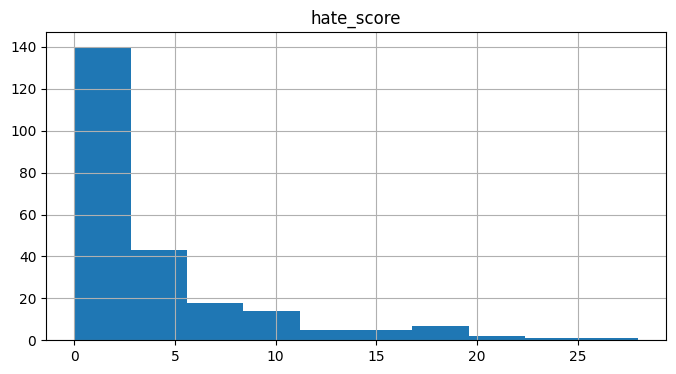

In [260]:
sotu_df.hist(column='hate_score')

Most scores are very low. Not a lot of hate speech in SOTU at least at first sight.

Finally, let's quickly plot the hate scores over time with `sotu_df.plot(x='year', y='hate_score', kind='scatter')`. We again see that there are only very few speeches that have scores significantly higher than 0.

<Axes: xlabel='year', ylabel='hate_score'>

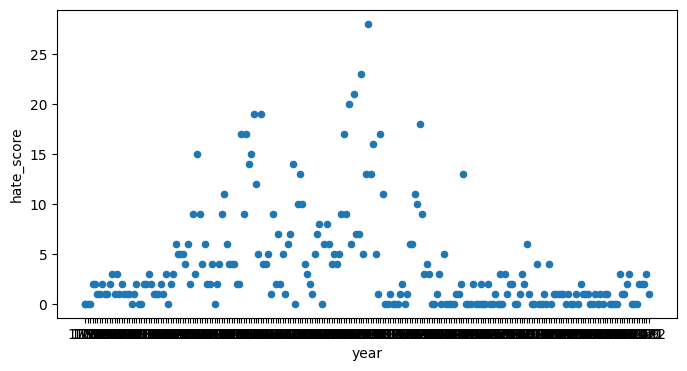

In [261]:
sotu_df.plot(x='year', y='hate_score', kind='scatter')

The speeches are very different in length. If we simply count the positive/negative words, it is much more likely that longer texts have more positive/negative words. Do you agree? We want to remove this bias.

In the language of text analysis, we have to normalize the scores. A simple but also crude way is to divide the score by the length of the speech. Earlier, we had to create a document-term-matrix first to do this, but we don't have to. Pandas also has a function `str.split()` that splits a text column into a list of words. Then, we can apply `len()` to get the length of that list.

Run:
```
speech_lengths = sotu_df['speechtext_clean'].str.split().apply(len)
speech_lengths[:5]
```

In [262]:
speech_lengths = sotu_df['speechtext_clean'].str.split().apply(len)
speech_lengths[:5]

,speechtext_clean
0,523
1,673
2,1117
3,1024
4,954


Create a new column 'hate_score_normalized' in `sotu_df`, which will include the values of `sotu_df['hate_score']/speech_lengths`.

In [266]:
sotu_df['hate_score_normalized'] = sotu_df['hate_score']/speech_lengths

Please, plot `sotu_df.hist(column='hate_score_normalized')`.

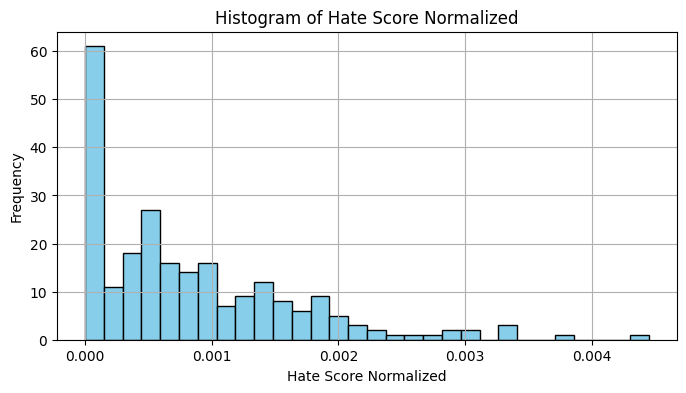

In [267]:
sotu_df.hist(column='hate_score_normalized', bins=30, color='skyblue', edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Hate Score Normalized')
plt.xlabel('Hate Score Normalized')
plt.ylabel('Frequency')

# Show the plot
plt.show()

Can you create a scatter plot like before, but with x='year' and y='hate_score_normalized'?

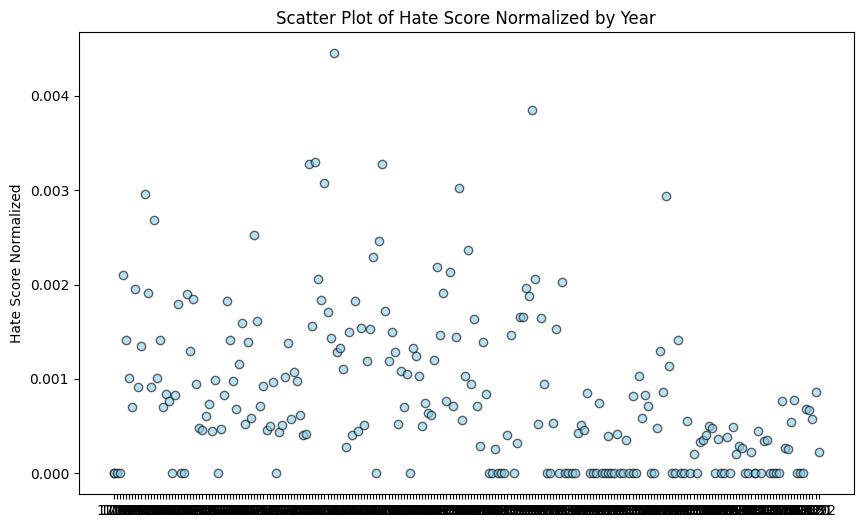

In [269]:
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size

plt.scatter(sotu_df['year'], sotu_df['hate_score_normalized'], color='skyblue', edgecolor='black', alpha=0.6)

# Adding titles and labels
plt.title('Scatter Plot of Hate Score Normalized by Year')
plt.ylabel('Hate Score Normalized')

# Show the plot
plt.show()

The scores are very low. There clearly is not much hate speech in the state of the unions - fortunately.

Let's try and select the three speeches with 'most' hate speech. Simply sort by hate_score_normalized in descending order and pick the top three. Collect these into a new dataframe `top_hate_three_df`. Do you remember how? Gemini should also be helpful here.

In [271]:
top_hate_three_df = sotu_df.sort_values(by='hate_score_normalized', ascending=False).head(3)
top_hate_three_df

,rownames,speechtext,year,date,speechtext_clean,hate_score,hate_score_normalized
73,18621201.html,Fellow-Citizens of the Senate and House of Re...,1862,1862-12-01,Senate House Representatives Since last annual...,19,0.004451
138,19271206.html,Members of the Congress: It is gratifying to ...,1927,1927-12-06,Members Congress It gratifying report fourth c...,18,0.003854
67,18561202.html,Fellow-Citizens of the Senate and of the Hous...,1856,1856-12-02,Senate House Representatives The Constitution ...,17,0.003304


Let's look at the one I have found on top. Run `top_hate_three_df.loc[73,'speechtext']`. Change the index if speech 73 was not your top one.

In [272]:
top_hate_three_df.loc[73,'speechtext']

" Fellow-Citizens of the Senate and House of Representatives: Since your last annual assembling another year of health and bountiful harvests has passed, and while it has not pleased the Almighty to bless us with a return of peace, we can but press on, guided by the best light He gives us, trusting that in His own good time and wise way all will yet be well. The correspondence touching foreign affairs which has taken place during the last year is herewith submitted, in virtual compliance with a request to that effect made by the House of Representatives near the close of the last session of Congress. If the condition of our relations with other nations is less gratifying than it has usually been at former periods, it is certainly more satisfactory than a nation so unhappily distracted as we are might reasonably have apprehended. In the month of June last there were some grounds to expect that the maritime powers which at the beginning of our domestic difficulties so unwisely and unnece

It is not at all clear what would be hate speech about speech 73. This dictionary-based method should indeed be used only with great care. But the corpus is also not relevant for this approach. It is just a demonstration.

Let's ask Gemini to download a dictionary of positive and negative sentiment words from the Internet and score `sotu_df['speechtext_clean']`. Print out the top scores.

This is quite hard, as we asking it to do everything.

This is very challenging for Gemini. For me, it was struggling with the encodings of the dictionary, which contain non-English words (https://realpython.com/python-encodings-guide/). But Gemini got it more or less right after a couple of attempts and requests to 'explain the error'. For me, it then delivered a standard sentiment analysis based on http://www.cs.uic.edu/~liub/FBS/.

In the workshops, we will work more with hate-speech detection but with Transformers. Hopefully, we will be producing better insights then.